In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Walkers with MPI: analysis
We have six trajectories jammed together in `HILLS_shared`.

I want to check if a proper reweight is possible. This time I have multiple `COLVAR` files, therefore it seems there are multiple reweights. We must apply the associated reweight factor to each point. For example, if we want to reweight `COLVAR.3`, we must multiply only the fourth point of the `HILLS_shared` file (every six). Alternatively, I can devise a script that performs the reweight over all the trajectories simultaneously. 

To see wheter this reweight is effective I can keep track of the distance between the $\alpha$-C of the coordinant oxygens' residues (because the coordination number is slowly varying). 

  

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/1167487326.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS_shared")


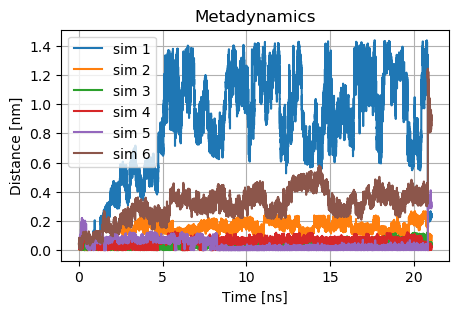

In [2]:
data_hills = plumed.read_as_pandas("HILLS_shared")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills["time"][::6]*0.001, data_hills["d1"][::6], label="sim 1")
plt.plot(data_hills["time"][1::6]*0.001, data_hills["d1"][1::6], label="sim 2")
plt.plot(data_hills["time"][2::6]*0.001, data_hills["d1"][2::6], label="sim 3")
plt.plot(data_hills["time"][3::6]*0.001, data_hills["d1"][3::6], label="sim 4")
plt.plot(data_hills["time"][4::6]*0.001, data_hills["d1"][4::6], label="sim 5")
plt.plot(data_hills["time"][5::6]*0.001, data_hills["d1"][5::6], label="sim 6")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

# A convergenza raggiunta, tutte e 6 le simulazioni dovrebbero diffondere liberamente. 

In [3]:
# Import data from the colvar files
data_colvar0 = plumed.read_as_pandas("data/COLVAR.0")
data_colvar1 = plumed.read_as_pandas("data/COLVAR.1")
data_colvar2 = plumed.read_as_pandas("data/COLVAR.2")
data_colvar3 = plumed.read_as_pandas("data/COLVAR.3")
data_colvar4 = plumed.read_as_pandas("data/COLVAR.4")
data_colvar5 = plumed.read_as_pandas("data/COLVAR.5")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/579429230.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar0 = plumed.read_as_pandas("data/COLVAR.0")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/579429230.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar1 = plumed.read_as_pandas("data/COLVAR.1")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/579429230.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar2 = plumed.read_as_pandas("data/COLVAR.2")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/579429230.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar3 = plumed.read_as_pandas("data/COLVAR.3")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/579429230.py:6: UserWarning: cannot load PLUMED instance, conversions will not be availa

Text(0, 0.5, 'Probability density')

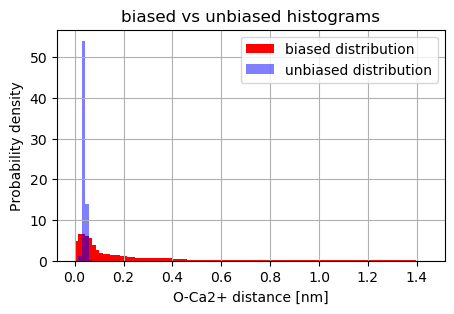

In [22]:
# Attento, qua devi prendere tutti i colvar contemporaneamente

w_0 = [math.exp(data_colvar0["metad.rbias"][i])/kT for i in range(0, len(data_colvar0["metad.rbias"]))]
w_1 = [math.exp(data_colvar1["metad.rbias"][i])/kT for i in range(0, len(data_colvar1["metad.rbias"]))]
w_2 = [math.exp(data_colvar2["metad.rbias"][i])/kT for i in range(0, len(data_colvar2["metad.rbias"]))]
w_3 = [math.exp(data_colvar3["metad.rbias"][i])/kT for i in range(0, len(data_colvar3["metad.rbias"]))]
w_4 = [math.exp(data_colvar4["metad.rbias"][i])/kT for i in range(0, len(data_colvar4["metad.rbias"]))]
w_5 = [math.exp(data_colvar5["metad.rbias"][i])/kT for i in range(0, len(data_colvar5["metad.rbias"]))]

w = np.concatenate((w_0, w_1, w_2, w_3, w_4, w_5), axis=None)
d1_colvar = np.concatenate((data_colvar0["d1"], data_colvar1["d1"], data_colvar2["d1"], data_colvar3["d1"], data_colvar4["d1"], data_colvar5["d1"]), axis=None)


val_bias, bins_bias, patches_bias = plt.hist(d1_colvar, bins=100, density=True, color='r', label="biased distribution")
kT = 1
val_unbias, bins_unbias, patches_unbias = plt.hist(d1_colvar, bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Reconstruct the free energy profile

In [19]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/1812908712.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


Text(0, 0.5, 'Free energy surface')

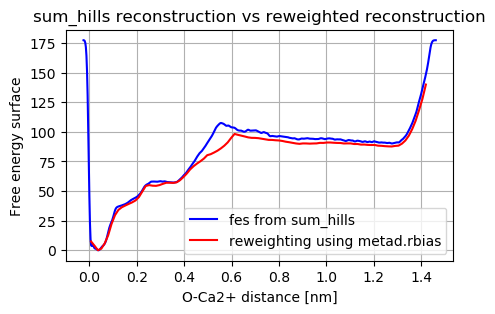

In [23]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)

data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"], data_fes["file.free"], 'b',label="fes from sum_hills")

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.grid()
plt.legend(loc="best")
plt.title("sum_hills reconstruction vs reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")
#plt.xlim([0, 1.2])

# Assessment of convergence

We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS_shared --stride 5000 --mintozero
```
We recall that in this simulation we deposited the Gaussian kernels with a `PACE=400`. Our time step is 0.002 ps, therefore the `HILLS` file contains values sampled every 0.8 ps. Consequently, plumed will identify the number of deposited Gaussian kernels as 

$$ \text{Number of simulations}\times \frac{\text{Simulated time [ps]}}{ \text{Pace of deposition [ps]}}=6\times\frac{21052}{0.8}=157890$$

Therefore our previous command will generate 155/5=31 files.

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/4251700578.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/4251700578.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/4251700578.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/4251700578.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_4419/4251700578.py:3: UserWarning: cannot load PLUMED instance, conversions will not be avail

Text(0, 0.5, 'Free energies [kJ/mol]')

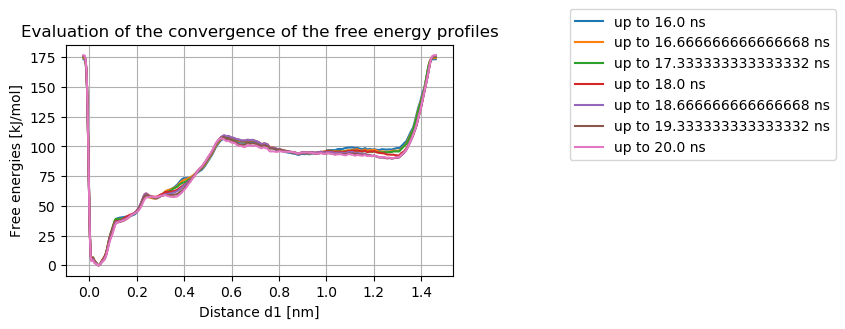

In [25]:

for i in range(24, 31):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
    plt.plot(data["d1"],data["file.free"], label="up to "+str(i * 5 * 0.8/6)+" ns")

plt.grid()
plt.title("Evaluation of the convergence of the free energy profiles")
plt.legend(loc=(1.3, 0.5))
plt.xlabel("Distance d1 [nm]")
plt.ylabel("Free energies [kJ/mol]")

## Important question about the reconstruction
How does plumed reconstruct the profile in `sum_hills`? We only have data until 0.08 nm and still he manages to go until 0.25 nm. 